# Proximal Policy Optimization in a Custom Pygame Shooting Game

#### Yuri Di Biasi 0001043300

## Imports

In [1]:
import gym
import numpy as np
import gym_game
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.optimizers import Adam
from keras import Model
from keras import backend as K
from scipy.stats import entropy

## Environment

In [2]:
ENVIRONMENT = "Pygame-v0"
env         = gym.make(ENVIRONMENT)

In [3]:
print(env.observation_space)

Box(0, 255, (300, 300, 3), uint8)


In [4]:
print(env.action_space)

Discrete(12)


Let's have a look at the observation

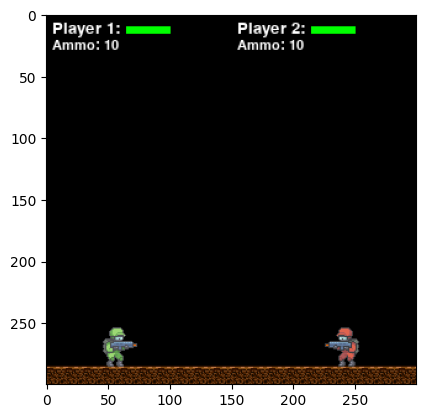

In [5]:
obs = env.reset()
plt.imshow(obs)

As stated in the paper, a series of preprocessing operations will be implemented to facilitate the task. To this end, we will utilize gym wrappers, which can be accessed via the following link: https://www.gymlibrary.dev/api/wrappers/

The preprocessing operations encompass the following steps:

-   Initial cropping of extraneous vertical screen elements.
-   Normalization of values by dividing them by 255.
-   Resizing the observation to a dimension of 84x84 pixels.
-   Stacking four consecutive frames to enable movement detection by the agent.
-   Additionally, reward normalization will be employed to enhance the stability of the learning process.

In [6]:
ENVIRONMENT             = "Pygame-v0"
VERTICAL_TOP_CROP       = 190
VERTICAL_BOTTOM_CROP    = -15
FRAME_STACK             = 4
RESIZED_WIDTH           = 84
RESIZED_HEIGHT          = 84

In [7]:
class CropObservation(gym.ObservationWrapper):
  
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, obs):
        return obs[VERTICAL_TOP_CROP:VERTICAL_BOTTOM_CROP,:]

In [8]:
class NormalizeObservation(gym.ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, obs):
        return np.divide(obs, 255.)

In [9]:
def create_environment():
  
  env = gym.make(ENVIRONMENT)
  env = gym.wrappers.NormalizeReward(env, gamma=0.99, epsilon=1e-8)
  env = CropObservation(env)
  env = NormalizeObservation(env)
  env = gym.wrappers.ResizeObservation(env, (RESIZED_WIDTH, RESIZED_HEIGHT))
  env = gym.wrappers.FrameStack(env, FRAME_STACK)
  
  return env

## Preprocessing results

In [10]:
env = create_environment()
obs = env.reset()

Let's have a look at the new observation space

In [11]:
env.observation_space.shape

(4, 84, 84, 3)

I have created a function specifically designed to display the new observation, which consists of four stacked frames.

In [12]:
def showObservation(obs):
    fig = plt.figure(figsize=(12, 8))
    for i in range(FRAME_STACK):
        fig.add_subplot(1, FRAME_STACK, i+1)
        plt.imshow(obs[i])
    plt.show()

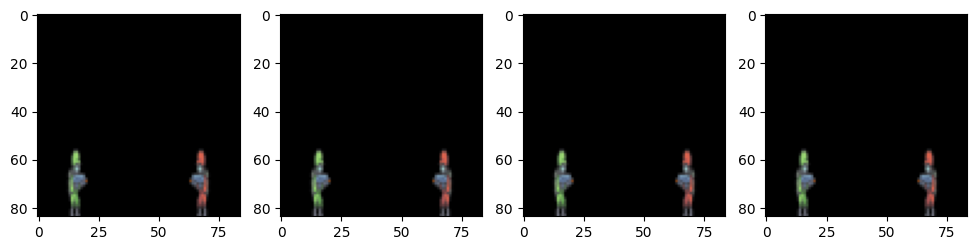

In [13]:
showObservation(obs)

As observed, the initial observation is formed by stacking the initial frame four times. Subsequently, when the agent performs an action, the resulting new state will be placed in the fourth position, as demonstrated in the following example:

In [14]:
obs, _ ,_ ,_ = env.step([4,0]) # action 4 means shooting, 0 none

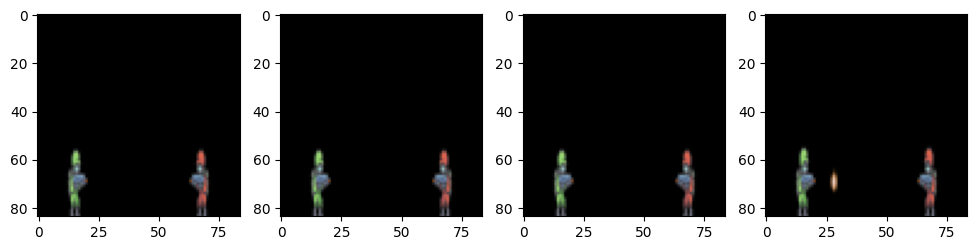

In [15]:
showObservation(obs)

## Neural Network Model

The chosen network architecture for our implementation is an Actor-Critic network, which closely follows the structure outlined in the paper "Playing Atari with Deep Reinforcement Learning".

In [16]:
input_shape = env.observation_space.shape
n_action    = env.action_space.n

In [17]:
def get_network():
    
  # Input layer
  inputs  = Input(shape=input_shape)

  # Convolutions on the frames on the screen
  layer1  = Conv2D(16, 8, strides = 4, activation = "relu")(inputs)
  layer2  = Conv2D(32, 4, strides = 2, activation = "relu")(layer1)

  # Flatten and add densely connected layer
  layer3  = Flatten()(layer2)
  layer4  = Dense(256, activation = "relu")(layer3)

  # Actor and critic layers
  actor   = Dense(n_action, activation = "softmax")(layer4)
  critic  = Dense(1, activation="linear")(layer4)

  return Model(inputs = inputs, outputs = [actor, critic])

In [18]:
model = get_network()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 84, 84,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 4, 20, 20, 1  3088        ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 9, 9, 32)  8224        ['conv2d[0][0]']                 
                                                                                              

## Proximal Policy Optimization

### Hyperparameters

I have adopted the hyperparameters recommended in the paper "Proximal Policy Optimization Algorithms" with a few modifications. Unlike the paper, I have chosen not to multiply the learning rate and clipping parameter by an alpha value, which consisted in gradually reducing it from 1 to 0 over the course of the learning process. Additionally, I have decided to use a higher learning rate based on extensive experimentation and time constraints, which has yielded satisfactory results. According to the paper's recommendations, it is advised to allow the agent to accumulate experiences for a fixed number of frames before applying a network update. It is suggested that this number should not surpass the duration of an episode. In this case, a horizon value of 64 frames was selected, despite the possibility of some episodes being shorter based on the agent's chosen actions. Notably, this parameter choice has yielded satisfactory results.

In [19]:
T                   = 64
ppo_epochs          = 3
learning_rate       = 1e-3
mini_batch_size     = 16
gamma               = 0.99
tau                 = 0.95
c1_coeff            = 1
c2_coeff            = 0.01
clip_param          = 0.1

optimizer           = Adam(learning_rate = learning_rate)

The compute_gae function computes the Generalized Advantage Estimation (GAE) returns in the Proximal Policy Optimization algorithm. The function begins by appending the next_value to the list of values to ensure consistency in the number of elements.

Next, the function iterates in reverse order over the range of the rewards list. For each step, it computes the temporal difference (delta) by subtracting the estimated value at the current step from the sum of the current reward, discounted future value, and a bootstrap term that accounts for incomplete episodes. The GAE is then updated by adding the delta, plus additional discounting factors (gamma and tau) that weigh the importance of immediate and future rewards.

Finally, the computed GAE plus the estimated value at the current step is inserted at the beginning of the returns list. Once the iteration is complete, the function returns the list of computed GAE returns.

In [20]:
def compute_gae(next_value, rewards, dones, values):
    values  = values + [next_value]
    gae     = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta   = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae     = delta + gamma * tau * (1 - dones[step]) * gae
        returns.insert(0, gae + values[step])
    return returns

The ppo_iter function generates minibatches from input batches for the Proximal Policy Optimization (PPO) algorithm.

A random permutation of indices is generated using the batch size. This permutation is applied to shuffle the states, actions, action probabilities, returns, and advantages arrays accordingly.

In [21]:
def ppo_iter(states, actions, actions_probabilities, returns, advantages):
    states                  = np.array(states)
    actions                 = np.array(actions)
    actions_probabilities   = np.array(actions_probabilities)
    returns                 = np.array(returns)
    advantages              = np.array(advantages)

    batch_size              = len(states)
    p                       = np.random.permutation(batch_size)

    states                  = states[p]
    actions                 = actions[p]
    actions_probabilities   = actions_probabilities[p]
    returns                 = returns[p]
    advantages              = advantages[p]
    
    for batch in range(batch_size // mini_batch_size):
        start   = batch*mini_batch_size
        end     = (batch + 1) * mini_batch_size
        indices = np.arange(start, end)
        yield states[indices], actions[indices], actions_probabilities[indices], returns[indices], advantages[indices]

The ppo_update function performs an update step in the Proximal Policy Optimization (PPO) algorithm.

Within each PPO epoch, the function utilizes the ppo_iter generator to obtain mini-batches that are used to compute the loss and update the model parameters.

For each mini-batch, a gradient tape is initiated to record the operations performed. The current_actor and current_critic are obtained by passing the state_batch to the model. The old_probs and new_probs represent the action probabilities corresponding to the selected actions in the respective batches.

The ratio is calculated as the exponential of the logarithmic difference between new_probs and old_probs. The surr1 and surr2 terms are computed based on the ratio and advantages_batch, with the latter being clipped within the specified clip_param range.

The actor_loss is computed as the negative mean of the minimum value between surr1 and surr2. The critic_loss is the mean squared difference between returns_batch and current_critic. The entropy_values represent the entropy of the current_actor probabilities, and entropy_bonus is the mean of these entropy values.

The total_loss is calculated by combining the actor_loss, critic_loss (multiplied by the c1_coeff), and entropy_bonus (multiplied by the c2_coeff).

In [22]:
def ppo_update(states, actions, actions_probabilities, returns, advantages):
    for _ in range(ppo_epochs):
        for state_batch, actions_batch, actions_probabilities_batch,\
            returns_batch, advantages_batch in\
            ppo_iter(states, actions, actions_probabilities,\
                     returns, advantages):
            
            with tf.GradientTape() as tape:
                current_actor, current_critic = model(state_batch)

                old_probs = [prob[actions_batch[i]] for i, prob in enumerate(actions_probabilities_batch)]
                new_probs = [prob[actions_batch[i]] for i, prob in enumerate(current_actor)]
                
                ratio = K.exp(K.log(new_probs) - K.log(old_probs))
                surr1 = ratio * advantages_batch
                surr2 = K.clip(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantages_batch

                actor_loss = -K.mean(K.min([surr1, surr2],axis=0))
                critic_loss = K.mean(K.square(returns_batch - current_critic))
                
                entropy_values = [entropy(probabilities) for probabilities in current_actor]
                entropy_bonus = K.mean(tf.convert_to_tensor(entropy_values, dtype=np.float32))
                
                total_loss = c1_coeff * critic_loss + actor_loss - c2_coeff * entropy_bonus
        
            gradients = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In this section, we initialize several variables that serve the purpose of evaluating results and tracking the training process. These variables are essential for monitoring and assessing the performance and progress of the training algorithm.

In [23]:
frame_idx               = 0
max_frames              = 2e6
agent_victories         = []
opponens_victories      = []
ties                    = []
consecutive_wins        = 0
early_stop              = False
n_games_test_training   = 5
positive_tests          = 30
frequency_test          = 2000
scores                  = {
    "Player 1"      : 0,
    "Player 2"      : 0,
    "Tie"           : 0,
    "Limit exceeded"  : 0
}

The test_env function serves the purpose of testing the environment at regular intervals throughout the learning process. This function is executed after a fixed number of frames and provides valuable insights into the progress of the training. By evaluating the environment during these test intervals, we can assess the effectiveness of the learning algorithm and gain valuable feedback on its performance.

In [24]:
def test_env(consecutive_wins, n_games_test = n_games_test_training, vis=True):
    for _ in range(n_games_test):
        state = env.reset()
        if vis: env.render()
        done = False
        while not done:
            state = tf.expand_dims(state, axis=0)
            dist, _ = model(state)
            next_state, reward, done, info = env.step([np.random.choice(n_action, p=np.squeeze(dist)), 4])
            state = next_state
            if vis: env.render()
        if info["victory"] != None:
            scores[info["victory"]] += 1
        else:
            scores["Limit exceeded"] += 1
    env.close()
    agent_victories.append(scores["Player 1"])
    opponens_victories.append(scores["Player 2"])
    ties.append(scores["Tie"])
    if len(agent_victories) > 2:
        if agent_victories[-1] == agent_victories[-2] + n_games_test:
            consecutive_wins += 1
        else:
            consecutive_wins = 0
    return consecutive_wins

Here the training process begins by allowing the agent to interact with the environment for a predetermined number of frames, following the current policy. This interaction gathers data, which is then used to calculate Generalized Advantage Estimations (GAE). Subsequently, the network is updated using these estimations.

In [ ]:
state = env.reset()

while frame_idx < max_frames and not early_stop:

    states                  = []
    actions                 = []
    rewards                 = []
    dones                   = []
    actions_probabilities   = []
    critic_values           = []

    for step in range(T):

        t_state = tf.expand_dims(state, axis=0)
        actor, critic = model(t_state)

        action_probability = np.squeeze(actor)
        
        action = np.random.choice(n_action, p = action_probability)
        next_state, reward, done, info = env.step([action, 4])

        states.append(state)
        actions.append(action)
        actions_probabilities.append(action_probability)
        critic_values.append(critic.numpy()[0])
        rewards.append(reward[0])
        dones.append(done)

        if done:
            state = env.reset()
        else:
            state = next_state
        
        if frame_idx % frequency_test == 0:
            consecutive_wins = test_env(consecutive_wins = consecutive_wins, n_games_test = n_games_test_training)
            print(scores)
            if consecutive_wins >= positive_tests:
                early_stop = True
                model.save_weights(f"player1_PPO_frame{frame_idx}")
        
        frame_idx += 1
    
    next_state = tf.expand_dims(next_state, axis=0)
    _, next_value = model(next_state)

    returns = compute_gae(next_value.numpy()[0], rewards, dones, critic_values)

    advantages = np.array(returns) - np.array(critic_values)
    
    ppo_update(states, actions, actions_probabilities, returns, advantages)


## Conclusion

Let's see how our agent behaves at the end of the training process.

In [25]:
model.load_weights("player1_PPO_frame136000.h5")

In [26]:
def play(episodes, show = False):
    env     = create_environment()
    wins    = 0
    defeats = 0
    ties    = 0
    for _ in range(episodes):
        state   = env.reset()
        done    = False
        while not done:
            if show: env.render()
            state = tf.expand_dims(state, axis=0)
            dist, _ = model(state)
            next_state, reward, done, info = env.step([np.random.choice(n_action, p=np.squeeze(dist)), 4])
            state = next_state
        if info["victory"] == "Player 1": wins += 1
        elif info["victory"] == "Player 2": defeats += 1
        elif info["victory"] == "Tie": ties += 1
    env.close()
    print(f"Games played: {episodes} - Results: {wins} victories, {defeats} defeats and {ties} ties.")

In [27]:
play(10, True)

Games played: 10 - Results: 10 victories, 0 defeats and 0 ties.


The results obtained from the agent's performance are encouraging. Although the agent may not have learned the optimal policy as it still fails to avoid all bullets, it demonstrates the ability to consistently win all games it plays. The observed outcome can be attributed to the reward design, which might not effectively incentivize the agent to avoid all bullets. By adapting the reward structure and incorporating variable frame skipping based on the players' positions, such as skipping more frames when they are far apart and fewer frames when they are close, it becomes plausible for the agent to acquire the capacity to play against itself and potentially even challenge human opponents. This adaptive approach holds the potential to enhance the agent's overall capabilities, enabling it to refine decision-making processes and optimize gameplay strategies. Through exposure to diverse scenarios and opponents, the agent can continuously improve its skills, leading to further advancements in its gameplay abilities.

## Resources and references

[PyGame Shooter Game Beginner Tutorial in Python](https://www.youtube.com/watch?v=DHgj5jhMJKg&list=PLjcN1EyupaQm20hlUE11y9y8EY2aXLpnv)


[Creating a Custom OpenAI Gym Environment](https://www.youtube.com/watch?v=ZxXKISVkH6Y)

[An introduction to Policy Gradient methods](https://www.youtube.com/watch?v=5P7I-xPq8u8)

[Proximal Policy Optimization | PPO Tutorial](https://www.youtube.com/watch?v=9DO63MSGeNA&t=301s)

[OpenAI Gym](https://www.gymlibrary.dev/), [Keras](https://keras.io/getting_started/) Documentation